# Autoencoder Approach to Feature Classification
The following is an attempt to improve the previous author's neural network classification approach by using autoencoders.  
The code from the original neural network approach can be found in the file "prepare_raw_data.py".  
It was copied into this jupyter notebook and updated to use Python 3.7 and Tensorflow 2 (which includes Keras).

Table of contents:  
[Preparing the Data and Autoencoders](#Preparing-the-Data-and-Autoencoders)  
[Undercomplete Autoencoders](#Undercomplete-Autoencoders)  
[Sparse Autoencoders](#Sparse-Autoencoders)  
[Deep Autoencoders](#Deep-Autoencoders)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import numpy as np
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
import json

This is the original author's code, just copied into separate cells of this jupyter notebook:

In [2]:
def get_busy_vs_relax_timeframes(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)
        try:
            tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 1))
            tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tasks_y = np.vstack((tasks_y, 0))
        except ValueError:
            continue
#             print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [3]:
def get_engagement_increase_vs_decrease_timeframes(path, ident, seconds):
    """Returns raw data from either engagement 'increase' or 'decrease' time frames and their class (0 or 1).
    TODO: join functions"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds * samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### engagement increase / decrease
        if task_num_table == 0:
            continue
        mid = int((relax_n[task_num_table][0] + relax_n[task_num_table][1])/2)
        length = int(samp_rate*30)
        for j in range(10):
            new_end = int(mid-j*samp_rate)

            new_start2 = int(mid+j*samp_rate)

            dataextract_decrease = dataextractor.DataExtractor(data[0][new_end - length:new_end],
                                                               data[1][new_end-length:new_end],
                                                               samp_rate)

            dataextract_increase = dataextractor.DataExtractor(data[0][new_start2: new_start2 + length],
                                                               data[1][new_start2: new_start2 + length], samp_rate)

            try:
                tasks_data = np.vstack((tasks_data, dataextract_increase.y))
                tasks_y = np.vstack((tasks_y, 1))
                tasks_data = np.vstack((tasks_data, dataextract_decrease.y))
                tasks_y = np.vstack((tasks_y, 0))
            except ValueError:
                print(ident)  # ignore short windows

    return tasks_data, tasks_y


In [4]:
def get_task_complexities_timeframes(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
        if cog_res['task_label'][task_num_table] != 'NC':
            continue
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [5]:
def get_TLX_timeframes(path, ident, seconds):
    """Returns raw data along with task load index class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17

        ### task load index
        if cog_res['task_complexity'][task_num_table] == 'medium' or cog_res['task_label'][task_num_table] != 'PT':
            continue
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            try:
                tasks_data = np.vstack((tasks_data, dataextract.y))
                tasks_y = np.vstack((tasks_y, cog_res['task_load_index'][task_num_table]))
            except ValueError:
                print(ident)

    return tasks_data, tasks_y


In [6]:
def get_data_from_idents(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    for i in idents:
        x, y = get_busy_vs_relax_timeframes(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
        # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
        # TODO: ^ modify, so that different functions can be accessible by parameter
        data = np.vstack((data, x))
        ys = np.vstack((ys, y))
    return data, ys


In [7]:
def model_build_reg():
    """Neural network model for regression problem."""

    print('Build model...')

    data_dim = 1

    # Convolution
    kernel_size = 10
    filters = 64
    strides = 4
    # pooling
    pool_size = 4

    # LSTM
    lstm_output_size = 256

    model = Sequential()
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    # #
    model.add(Dropout(0.25))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['mae'])

    return model


In [8]:
def model_build_multi():
    """Neural network model for multi class problem."""

    print('Build model...')

    # Convolution
    kernel_size = 10
    filters = 64
    strides = 4
    # pooling
    pool_size = 4

    # LSTM
    lstm_output_size = 256

    model = Sequential()
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))

    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(0.25))
    model.add(LSTM(lstm_output_size))
    # model.add(Dense(1))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [9]:
def model_build_bin():
    """Neural network model for binary problem."""

    print('Build model...')

    # Convolution
    kernel_size = 200
    filters = 64
    strides = 4
    # pooling
    pool_size = 4
    # LSTM
    lstm_output_size = 256

    model = Sequential()
    model.add(Dropout(0.25))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=strides))

    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides))
    model.add(MaxPooling1D(pool_size=pool_size))
    # #
    model.add(Dropout(0.25))
    model.add(LSTM(lstm_output_size))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [10]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    print('Train...')
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)
    return score, acc, epoch_data


In [11]:
def sequence_padding(x, maxlen):
    """Pad sequences (all have to be same length)."""
    print('Pad sequences (samples x time)')
    return sequence.pad_sequences(x, maxlen=maxlen, dtype=np.float)


In [12]:
def __main__():
    path = '../../StudyData/' #'E:/signal_acquiring/'

#     idents = ['1mpau']
    idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']

    # idents = ['7dwjy', 'bd47a', 'f1gjp', 'hpbxa', 'l53hg', 'tn4vl']
    # idents = ['94mnx', 'fzchw', 'ef5rq', 'iz2ps', 'c24ur', 'td5pr', '3n2f9', 'r89k1']

    user_epoch_data = {}
    seconds = 30  # time window length

    # leave out person out validation
    # range 1 while testing, todo: change back to len(idents)
    for ident in range(1):#len(idents)):
        train_idents = [x for i, x in enumerate(idents) if i != ident]
        validation_idents = [idents[ident]]
        test_idents = [idents[ident]]

        x_train, y_train = get_data_from_idents(path, train_idents, seconds)
        x_valid, y_valid = get_data_from_idents(path, validation_idents, seconds)
        x_test, y_test = get_data_from_idents(path, test_idents, seconds)

        x_train = x_train.reshape(-1, x_train[0].shape[0], 1)
        x_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
        x_test = x_test.reshape(-1, x_test[0].shape[0], 1)
        
        # Training
        batch_size = 128
        epochs = 100

        model = model_build_bin()
        # model = model_build_multi()
        # model = model_build_reg()
        
        sc, curr_acc, epoch_data = model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test,
                                               y_test)

        epoch_data.history['user_id'] = idents[ident]
        user_epoch_data[idents[ident]] = epoch_data.history

        jsonformat = json.dumps(str(user_epoch_data))
        f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
        f.write(jsonformat)
        f.close()


In [13]:
__main__()

Build model...
Train...
34/34 [==============================] - 0s 0s/sample - loss: 0.4648 - accuracy: 0.7353
Test score: 0.4647641181945801
Test accuracy: 0.7352941


# Preparing the Data and Autoencoders

In [14]:
#Imports
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64') # call this, to set keras to use float64 to avoid a warning message
numpy.random.seed(42)
tf.random.set_seed(42)

### Prepare the Data
Read the data from files and store it into arrays.

In [15]:
# Mostly a copy of the code in __main__(), used for reading the data into an array
seconds = 30  # time window length
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../StudyData/'

train_idents = idents[:-1]
validation_idents = [idents[-1]]
test_idents = [idents[-1]]

x_train, y_train = get_data_from_idents(path, train_idents, seconds)
x_valid, y_valid = get_data_from_idents(path, validation_idents, seconds)
x_test, y_test = get_data_from_idents(path, test_idents, seconds)

# x_train = x_train.reshape(-1, x_train[0].shape[0], 1)
# x_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
# x_test = x_test.reshape(-1, x_test[0].shape[0], 1)

print("x_train shape:", x_train.shape, "  x_test shape:", x_test.shape)

x_train shape: (722, 1290)   x_test shape: (28, 1290)


### Preprocess the Data
Prepare two versions of the data:
- Normalize original data (**x_\***): reffered to as **normalized data** from now on,
- subsampled, filtered, then normalized data (**x2_\***): reffered to as **shortened data** form now on.

In [16]:
from scipy.ndimage.filters import gaussian_filter1d

step = 5 # take each step-th element of the array
sigma = 1 # sigma for gaussian filter

def convolve(x): # helper function for applying along axis
    tmp = gaussian_filter1d(x, sigma=sigma, mode="mirror")
    tmp = normalize(tmp)
    return tmp

def normalize(x): # helper function for applying along axis
    #normalize the data
    tmp = x
    tmp_min = np.min(tmp)
    tmp_max = np.max(tmp)
    top_norm = tmp-tmp_min
    bot_norm = tmp_max-tmp_min
    if (bot_norm == 0): # avoid division by 0
        bot_norm = 1
    tmp = top_norm/bot_norm
    return tmp

# Prepare another set of data that is subsampled, filtered and normalized
# Use np.apply_along_axis to apply the above function to each row of the array separately
x2_train = x_train[:,1::step]
x2_train = np.apply_along_axis(convolve, 1, x2_train)

x2_valid = x_valid[:,1::step]
x2_valid = np.apply_along_axis(convolve, 1, x2_valid)

x2_test = x_test[:,1::step]
x2_test = np.apply_along_axis(convolve, 1, x2_test)

# Normalize original (normalized) data
# Use np.apply_along_axis to apply the above function to each row of the array separately
x_train = np.apply_along_axis(normalize, 1, x_train)
x_valid = np.apply_along_axis(normalize, 1, x_valid)
x_test = np.apply_along_axis(normalize, 1, x_test)

print("Normalized data:", x_test.shape, "  Shortened data:", x2_test.shape)

Normalized data: (28, 1290)   Shortened data: (28, 258)


<Figure size 432x288 with 0 Axes>

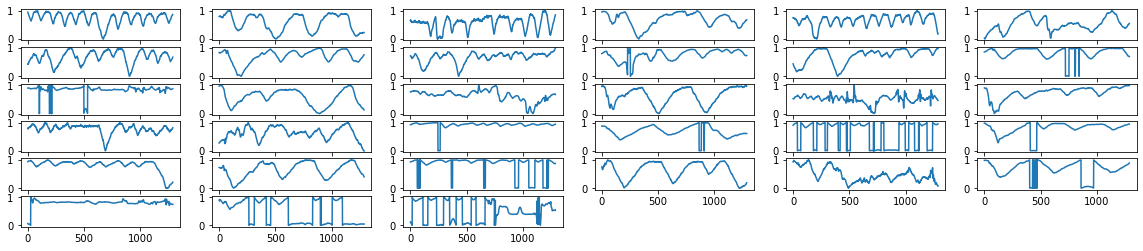

<Figure size 432x288 with 0 Axes>

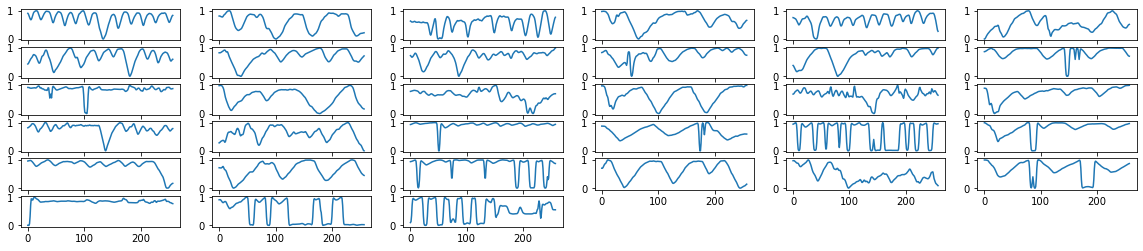

In [17]:
#plot n samples to compare the normalized data to the shortened data
n = 33

#plot some normalized data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])

#plot some shortened data values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])

### Prepare a Classifier  
Prepare a function that builds a new model, that will get attached to the encoded part of the autoencoder.  
**Work in progress**

In [18]:
def classifier(model):
    # Todo: make a better model
    
    # Convolution
    kernel_size = 16
    filters = 16
    strides = 1
    # pooling
    pool_size = 2
    # LSTM
    lstm_output_size = 32

    model = layers.Reshape((-1, 1), input_shape=(model.shape)) (model)
#     model = Dropout(0.25) (model)

    model = Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides) (model)
    model = MaxPooling1D(pool_size=pool_size) (model)

    model = LSTM(lstm_output_size, activation='sigmoid') (model)
    model = Dense(1, activation='sigmoid') (model)
    return model

### Undercomplete Autoencoders
from https://blog.keras.io/building-autoencoders-in-keras.html

In [19]:
def undercomplete_ae(x, encoding_dim=64):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.25, name="dropout")(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder =  Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return autoencoder, encoded

#### Undercomplete Autoencoder - Normalized Input Data

Build the autoencoder:

In [20]:
autoencoder, _ = undercomplete_ae(x_train, 128)

Print the summary of the autoencoder:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1290)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1290)              0         
_________________________________________________________________
encoded (Dense)              (None, 128)               165248    
_________________________________________________________________
decoded (Dense)              (None, 1290)              166410    
Total params: 331,658
Trainable params: 331,658
Non-trainable params: 0
_________________________________________________________________


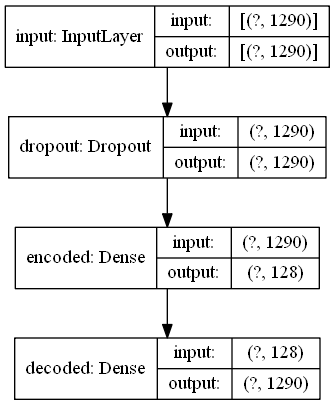

In [21]:
autoencoder.summary()
keras.utils.plot_model(autoencoder, "./AEOutput/undercomplete_ae.png", show_shapes=True)

Train the model:

In [22]:
# Training
batch_size = 256
epochs = 100

# Fit the model
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 722 samples, validate on 28 samples
Epoch 1/100
722/722 [==============================] - 1s 802us/sample - loss: 0.6982 - accuracy: 7.7949e-04 - val_loss: 0.6933 - val_accuracy: 8.5825e-04
Epoch 2/100
722/722 [==============================] - 0s 139us/sample - loss: 0.6930 - accuracy: 7.7949e-04 - val_loss: 0.6935 - val_accuracy: 6.3677e-04
Epoch 3/100
722/722 [==============================] - 0s 117us/sample - loss: 0.6924 - accuracy: 7.6231e-04 - val_loss: 0.6937 - val_accuracy: 5.8140e-04
Epoch 4/100
722/722 [==============================] - 0s 139us/sample - loss: 0.6914 - accuracy: 7.8056e-04 - val_loss: 0.6935 - val_accuracy: 7.4751e-04
Epoch 5/100
722/722 [==============================] - 0s 139us/sample - loss: 0.6900 - accuracy: 7.8915e-04 - val_loss: 0.6948 - val_accuracy: 6.6445e-04
Epoch 6/100
722/722 [==============================] - 0s 130us/sample - loss: 0.6881 - accuracy: 8.1170e-04 - val_loss: 0.6942 - val_accuracy: 6.6445e-04
Epoch 7/100
722/722 [====

Epoch 55/100
722/722 [==============================] - 0s 114us/sample - loss: 0.5826 - accuracy: 0.0012 - val_loss: 0.6379 - val_accuracy: 0.0011
Epoch 56/100
722/722 [==============================] - 0s 117us/sample - loss: 0.5813 - accuracy: 0.0012 - val_loss: 0.6371 - val_accuracy: 0.0011
Epoch 57/100
722/722 [==============================] - 0s 139us/sample - loss: 0.5804 - accuracy: 0.0012 - val_loss: 0.6486 - val_accuracy: 0.0011
Epoch 58/100
722/722 [==============================] - 0s 130us/sample - loss: 0.5807 - accuracy: 0.0012 - val_loss: 0.6382 - val_accuracy: 0.0011
Epoch 59/100
722/722 [==============================] - 0s 117us/sample - loss: 0.5791 - accuracy: 0.0012 - val_loss: 0.6304 - val_accuracy: 0.0011
Epoch 60/100
722/722 [==============================] - 0s 139us/sample - loss: 0.5774 - accuracy: 0.0012 - val_loss: 0.6502 - val_accuracy: 0.0011
Epoch 61/100
722/722 [==============================] - 0s 117us/sample - loss: 0.5782 - accuracy: 0.0012 - val_

Plot some input data and the corresponding reconstructed data: 

<Figure size 432x288 with 0 Axes>

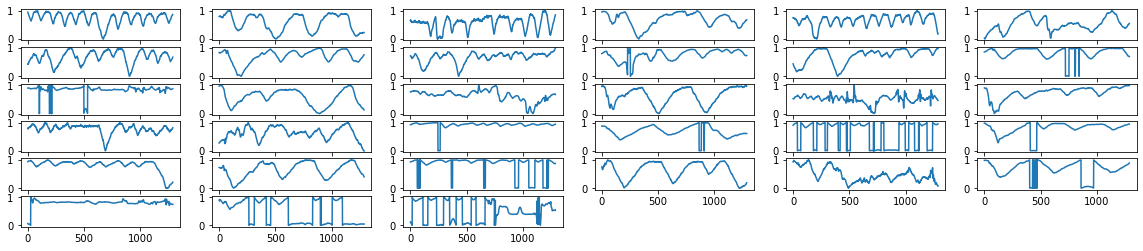

<Figure size 432x288 with 0 Axes>

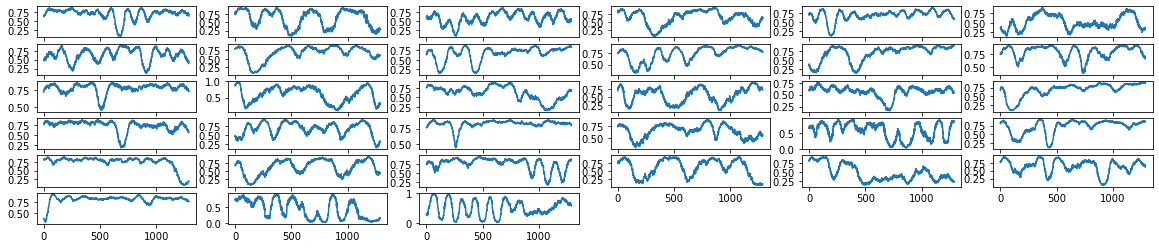

In [23]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare the input and reconstruction
n = 33

#plot the input values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])

Combine the encoder layer and the classification model:

In [24]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if i != ident]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    xt_train = np.apply_along_axis(normalize, 1, xt_train)
    xt_valid = np.apply_along_axis(normalize, 1, xt_valid)
    xt_test = np.apply_along_axis(normalize, 1, xt_test)

    # AE Training
    batch_size = 256
    epochs = 100

    autoencoder, encoded = undercomplete_ae(x_train, 100)
    
    print("\n\nAUTOENCODER TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder, xt_train, xt_train, batch_size, epochs,
                                           xt_valid, xt_valid, xt_test, xt_test)

    model = classifier(encoded)

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, xt_train, yt_train, batch_size, epochs,
                                           xt_valid, yt_valid, xt_test, yt_test)

    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()



AUTOENCODER TRAINING:  0
Train...
34/34 [==============================] - 0s 0s/sample - loss: 0.5179 - accuracy: 0.0013
Test score: 0.5178926999078077
Test accuracy: 0.0012767897856817145


CLASSIFICATION TRAINING:  0
Train...
34/34 [==============================] - 0s 459us/sample - loss: 0.6744 - accuracy: 0.5588
Test score: 0.6744193106013185
Test accuracy: 0.5588235294117647


AUTOENCODER TRAINING:  1
Train...
36/36 [==============================] - 0s 434us/sample - loss: 0.5441 - accuracy: 0.0013
Test score: 0.5440721950597234
Test accuracy: 0.0013135228251507322


CLASSIFICATION TRAINING:  1
Train...
36/36 [==============================] - 0s 181us/sample - loss: 0.5867 - accuracy: 0.7500
Test score: 0.5867079452921947
Test accuracy: 0.75


AUTOENCODER TRAINING:  2
Train...
34/34 [==============================] - 0s 191us/sample - loss: 0.5968 - accuracy: 0.0014
Test score: 0.596770762520678
Test accuracy: 0.0014135886912904697


CLASSIFICATION TRAINING:  2
Train...
34/3

#### Undercomplete Autoencoder - Shortened Input Data

Build the autoencoder:

In [25]:
autoencoder2, _ = undercomplete_ae(x2_train, 100)

Print the summary of the autoencoder:

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 258)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 258)               0         
_________________________________________________________________
encoded (Dense)              (None, 100)               25900     
_________________________________________________________________
decoded (Dense)              (None, 258)               26058     
Total params: 51,958
Trainable params: 51,958
Non-trainable params: 0
_________________________________________________________________


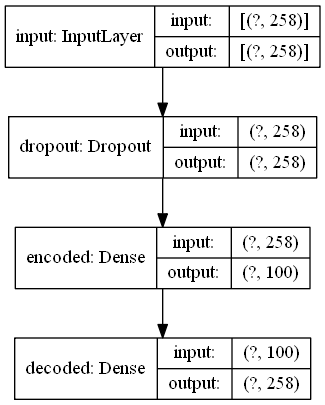

In [26]:
autoencoder2.summary()
keras.utils.plot_model(autoencoder2, "./AEOutput/undercomplete_ae2.png", show_shapes=True)

Train the model:

In [27]:
# Training
batch_size = 256
epochs = 100

# Fit the model
autoencoder2.fit(x2_train, x2_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x2_test, x2_test))

Train on 722 samples, validate on 28 samples
Epoch 1/100
722/722 [==============================] - 0s 503us/sample - loss: 0.7160 - accuracy: 0.0039 - val_loss: 0.6996 - val_accuracy: 0.0032
Epoch 2/100
722/722 [==============================] - 0s 22us/sample - loss: 0.7004 - accuracy: 0.0039 - val_loss: 0.6964 - val_accuracy: 0.0035
Epoch 3/100
722/722 [==============================] - 0s 43us/sample - loss: 0.6950 - accuracy: 0.0039 - val_loss: 0.6957 - val_accuracy: 0.0036
Epoch 4/100
722/722 [==============================] - 0s 22us/sample - loss: 0.6919 - accuracy: 0.0040 - val_loss: 0.6948 - val_accuracy: 0.0036
Epoch 5/100
722/722 [==============================] - 0s 31us/sample - loss: 0.6905 - accuracy: 0.0040 - val_loss: 0.6942 - val_accuracy: 0.0036
Epoch 6/100
722/722 [==============================] - 0s 22us/sample - loss: 0.6884 - accuracy: 0.0041 - val_loss: 0.6939 - val_accuracy: 0.0037
Epoch 7/100
722/722 [==============================] - 0s 43us/sample - loss: 

722/722 [==============================] - 0s 31us/sample - loss: 0.5715 - accuracy: 0.0070 - val_loss: 0.6044 - val_accuracy: 0.0069
Epoch 57/100
722/722 [==============================] - 0s 22us/sample - loss: 0.5707 - accuracy: 0.0071 - val_loss: 0.6106 - val_accuracy: 0.0069
Epoch 58/100
722/722 [==============================] - 0s 22us/sample - loss: 0.5683 - accuracy: 0.0070 - val_loss: 0.6014 - val_accuracy: 0.0069
Epoch 59/100
722/722 [==============================] - 0s 43us/sample - loss: 0.5676 - accuracy: 0.0072 - val_loss: 0.6016 - val_accuracy: 0.0069
Epoch 60/100
722/722 [==============================] - 0s 22us/sample - loss: 0.5655 - accuracy: 0.0070 - val_loss: 0.6095 - val_accuracy: 0.0068
Epoch 61/100
722/722 [==============================] - 0s 31us/sample - loss: 0.5657 - accuracy: 0.0070 - val_loss: 0.5991 - val_accuracy: 0.0069
Epoch 62/100
722/722 [==============================] - 0s 22us/sample - loss: 0.5642 - accuracy: 0.0071 - val_loss: 0.5956 - val_a

Plot some input data and the corresponding reconstructed data: 

<Figure size 432x288 with 0 Axes>

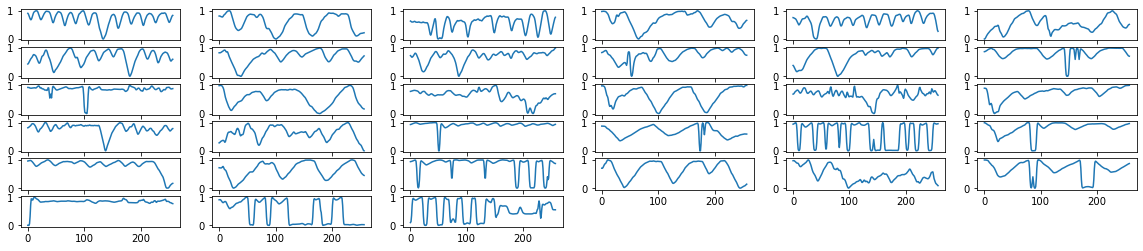

<Figure size 432x288 with 0 Axes>

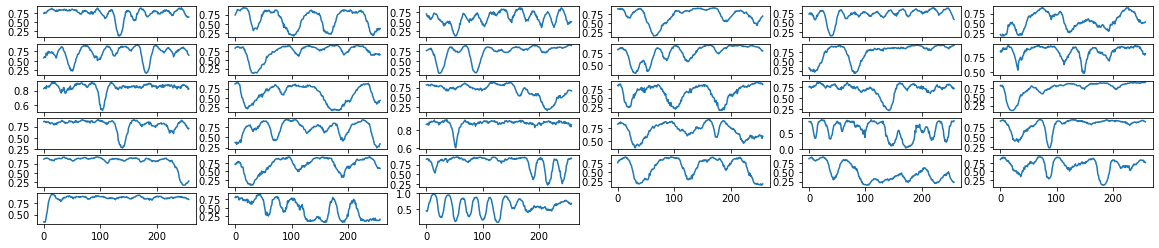

In [28]:
x2_pred = autoencoder2.predict(x2_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_pred[i])

Combine the encoder layer and the classification model:

In [29]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if i != ident]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    x2t_train = xt_train[:,1::step]
    x2t_train = np.apply_along_axis(convolve, 1, x2t_train)

    x2t_valid = xt_valid[:,1::step]
    x2t_valid = np.apply_along_axis(convolve, 1, x2t_valid)

    x2t_test = xt_test[:,1::step]
    x2t_test = np.apply_along_axis(convolve, 1, x2t_test)

    # AE Training
    batch_size = 256
    epochs = 100

    # this model maps an input to its reconstruction
    autoencoder2, encoded = undercomplete_ae(x2_train, 100)
    
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder2, x2t_train, x2t_train, batch_size, epochs,
                                           x2t_valid, x2t_valid, x2t_test, x2t_test)

    model = classifier(encoded)

    model = Model(inputs=autoencoder2.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, x2t_train, yt_train, batch_size, epochs,
                                           x2t_valid, yt_valid, x2t_test, yt_test)

    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()



AE TRAINING:  0
Train...
34/34 [==============================] - 0s 59us/sample - loss: 0.4761 - accuracy: 0.0074
Test score: 0.4760960419388378
Test accuracy: 0.007409940720474236


CLASSIFICATION TRAINING:  0
Train...
34/34 [==============================] - 0s 0s/sample - loss: 0.5480 - accuracy: 0.7647
Test score: 0.5480311830692431
Test accuracy: 0.7647058823529411


AE TRAINING:  1
Train...
36/36 [==============================] - 0s 434us/sample - loss: 0.5180 - accuracy: 0.0074
Test score: 0.5179973393678665
Test accuracy: 0.007428940568475453


CLASSIFICATION TRAINING:  1
Train...
36/36 [==============================] - 0s 305us/sample - loss: 0.6267 - accuracy: 0.6667
Test score: 0.6266789452897178
Test accuracy: 0.6666666666666666


AE TRAINING:  2
Train...
34/34 [==============================] - 0s 59us/sample - loss: 0.5744 - accuracy: 0.0073
Test score: 0.5744113036814857
Test accuracy: 0.00729594163246694


CLASSIFICATION TRAINING:  2
Train...
34/34 [===============

### Sparse Autoencoders

In [30]:
def sparse_ae(x, encoding_dim=64):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.25, name="dropout") (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return autoencoder, encoded

#### Sparse Autoencoder - Normalized Input Data

Build the autoencoder:

In [31]:
autoencoder, _ = sparse_ae(x_train, 100)

Print the summary of the autoencoder:

Model: "sparse_ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1290)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1290)              0         
_________________________________________________________________
encoded (Dense)              (None, 100)               129100    
_________________________________________________________________
decoded (Dense)              (None, 1290)              130290    
Total params: 259,390
Trainable params: 259,390
Non-trainable params: 0
_________________________________________________________________


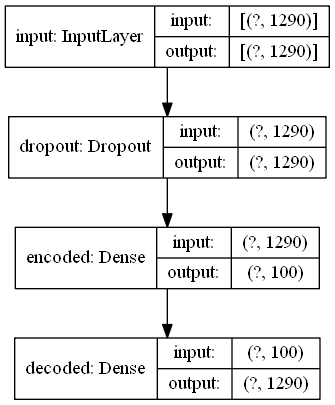

In [32]:
autoencoder.summary()
keras.utils.plot_model(autoencoder, "./AEOutput/sparse_ae.png", show_shapes=True)

Compile and train the model:

In [33]:
# Training
batch_size = 256
epochs = 100

# Fit the model
autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 722 samples, validate on 28 samples
Epoch 1/100
722/722 [==============================] - 0s 666us/sample - loss: 0.6984 - accuracy: 7.9667e-04 - val_loss: 0.6931 - val_accuracy: 7.7519e-04
Epoch 2/100
722/722 [==============================] - 0s 118us/sample - loss: 0.6932 - accuracy: 7.8808e-04 - val_loss: 0.6930 - val_accuracy: 7.1982e-04
Epoch 3/100
722/722 [==============================] - 0s 124us/sample - loss: 0.6931 - accuracy: 7.6016e-04 - val_loss: 0.6928 - val_accuracy: 7.1982e-04
Epoch 4/100
722/722 [==============================] - 0s 115us/sample - loss: 0.6930 - accuracy: 7.8915e-04 - val_loss: 0.6927 - val_accuracy: 7.1982e-04
Epoch 5/100
722/722 [==============================] - 0s 116us/sample - loss: 0.6929 - accuracy: 7.8700e-04 - val_loss: 0.6925 - val_accuracy: 8.0288e-04
Epoch 6/100
722/722 [==============================] - 0s 117us/sample - loss: 0.6928 - accuracy: 7.6875e-04 - val_loss: 0.6921 - val_accuracy: 7.7519e-04
Epoch 7/100
722/722 [====

722/722 [==============================] - 0s 112us/sample - loss: 0.6115 - accuracy: 0.0011 - val_loss: 0.6624 - val_accuracy: 9.9668e-04
Epoch 55/100
722/722 [==============================] - 0s 111us/sample - loss: 0.6111 - accuracy: 0.0011 - val_loss: 0.6523 - val_accuracy: 0.0010
Epoch 56/100
722/722 [==============================] - 0s 120us/sample - loss: 0.6097 - accuracy: 0.0011 - val_loss: 0.6574 - val_accuracy: 0.0010
Epoch 57/100
722/722 [==============================] - 0s 120us/sample - loss: 0.6081 - accuracy: 0.0012 - val_loss: 0.6581 - val_accuracy: 9.9668e-04
Epoch 58/100
722/722 [==============================] - 0s 115us/sample - loss: 0.6078 - accuracy: 0.0011 - val_loss: 0.6501 - val_accuracy: 0.0010
Epoch 59/100
722/722 [==============================] - 0s 113us/sample - loss: 0.6064 - accuracy: 0.0012 - val_loss: 0.6606 - val_accuracy: 9.9668e-04
Epoch 60/100
722/722 [==============================] - 0s 116us/sample - loss: 0.6058 - accuracy: 0.0011 - val_l

Plot some input data and the corresponding reconstructed data: 

<Figure size 432x288 with 0 Axes>

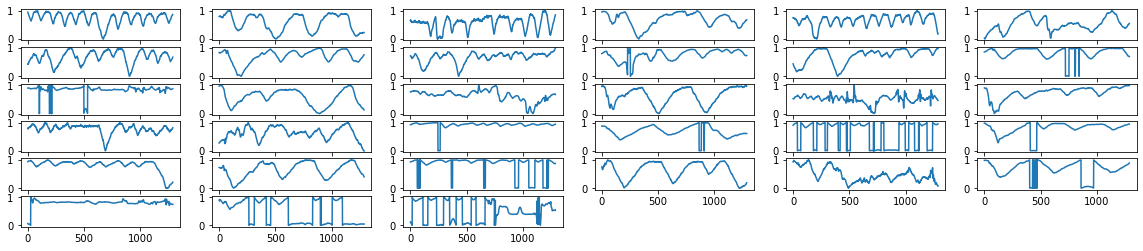

<Figure size 432x288 with 0 Axes>

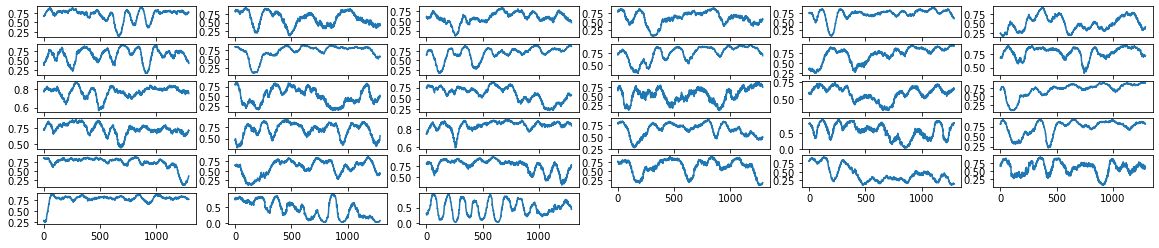

In [34]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare the input and reconstruction
n = 33

#plot the input values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])

Combine the encoder layer and the classification model:

In [35]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if i != ident]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    xt_train = np.apply_along_axis(normalize, 1, xt_train)
    xt_valid = np.apply_along_axis(normalize, 1, xt_valid)
    xt_test = np.apply_along_axis(normalize, 1, xt_test)

    # AE Training
    batch_size = 256
    epochs = 100

    autoencoder, encoded = sparse_ae(x_train, 100)
    
    print("\n\nAUTOENCODER TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder, xt_train, xt_train, batch_size, epochs,
                                           xt_valid, xt_valid, xt_test, xt_test)

    model = classifier(encoded)

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, xt_train, yt_train, batch_size, epochs,
                                           xt_valid, yt_valid, xt_test, yt_test)

    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()



AUTOENCODER TRAINING:  0
Train...
34/34 [==============================] - 0s 88us/sample - loss: 0.5735 - accuracy: 0.0013
Test score: 0.5734665831808354
Test accuracy: 0.0012539899680802553


CLASSIFICATION TRAINING:  0
Train...
34/34 [==============================] - 0s 264us/sample - loss: 0.4859 - accuracy: 0.7647
Test score: 0.4859148959614853
Test accuracy: 0.7647058823529411


AUTOENCODER TRAINING:  1
Train...
36/36 [==============================] - 0s 111us/sample - loss: 0.5679 - accuracy: 0.0012
Test score: 0.5679485316378695
Test accuracy: 0.0012058570198105081


CLASSIFICATION TRAINING:  1
Train...
36/36 [==============================] - 0s 222us/sample - loss: 0.5564 - accuracy: 0.7500
Test score: 0.5563743187621472
Test accuracy: 0.75


AUTOENCODER TRAINING:  2
Train...
34/34 [==============================] - 0s 88us/sample - loss: 0.6152 - accuracy: 0.0014
Test score: 0.6152134768905819
Test accuracy: 0.0013679890560875513


CLASSIFICATION TRAINING:  2
Train...
34

#### Sparse Autoencoder - Shortened Input Data

Build the autoencoder:

In [36]:
autencoder2 = sparse_ae(x2_train, 100)

Print the summary of the autoencoder:

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 258)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 258)               0         
_________________________________________________________________
encoded (Dense)              (None, 100)               25900     
_________________________________________________________________
decoded (Dense)              (None, 258)               26058     
Total params: 51,958
Trainable params: 51,958
Non-trainable params: 0
_________________________________________________________________


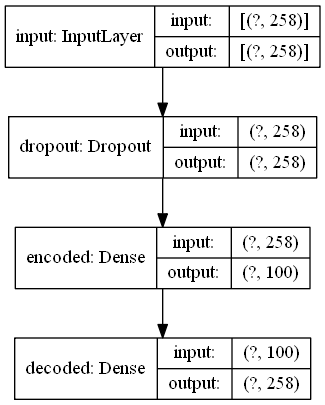

In [37]:
autoencoder2.summary()
keras.utils.plot_model(autoencoder2, "./AEOutput/sparse_ae2.png", show_shapes=True)

Train the model:

In [38]:
# Training
batch_size = 256
epochs = 100

# Fit the model
autoencoder2.fit(x2_train, x2_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x2_test, x2_test))

Train on 722 samples, validate on 28 samples
Epoch 1/100
722/722 [==============================] - 0s 35us/sample - loss: 0.8282 - accuracy: 0.0050 - val_loss: 0.7094 - val_accuracy: 0.0053
Epoch 2/100
722/722 [==============================] - 0s 32us/sample - loss: 0.7023 - accuracy: 0.0051 - val_loss: 0.7724 - val_accuracy: 0.0048
Epoch 3/100
722/722 [==============================] - 0s 32us/sample - loss: 0.6921 - accuracy: 0.0050 - val_loss: 0.6715 - val_accuracy: 0.0053
Epoch 4/100
722/722 [==============================] - 0s 32us/sample - loss: 0.6299 - accuracy: 0.0057 - val_loss: 0.6421 - val_accuracy: 0.0057
Epoch 5/100
722/722 [==============================] - 0s 32us/sample - loss: 0.6469 - accuracy: 0.0058 - val_loss: 0.6382 - val_accuracy: 0.0061
Epoch 6/100
722/722 [==============================] - 0s 30us/sample - loss: 0.6271 - accuracy: 0.0060 - val_loss: 0.6454 - val_accuracy: 0.0061
Epoch 7/100
722/722 [==============================] - 0s 30us/sample - loss: 0

722/722 [==============================] - 0s 29us/sample - loss: 0.5428 - accuracy: 0.0072 - val_loss: 0.5690 - val_accuracy: 0.0069
Epoch 57/100
722/722 [==============================] - 0s 30us/sample - loss: 0.5422 - accuracy: 0.0073 - val_loss: 0.5691 - val_accuracy: 0.0071
Epoch 58/100
722/722 [==============================] - 0s 29us/sample - loss: 0.5416 - accuracy: 0.0072 - val_loss: 0.5679 - val_accuracy: 0.0069
Epoch 59/100
722/722 [==============================] - 0s 30us/sample - loss: 0.5409 - accuracy: 0.0072 - val_loss: 0.5678 - val_accuracy: 0.0069
Epoch 60/100
722/722 [==============================] - 0s 30us/sample - loss: 0.5407 - accuracy: 0.0072 - val_loss: 0.5671 - val_accuracy: 0.0068
Epoch 61/100
722/722 [==============================] - 0s 36us/sample - loss: 0.5410 - accuracy: 0.0073 - val_loss: 0.5672 - val_accuracy: 0.0069
Epoch 62/100
722/722 [==============================] - 0s 39us/sample - loss: 0.5401 - accuracy: 0.0072 - val_loss: 0.5658 - val_a

Plot some input data and the corresponding reconstructed data: 

<Figure size 432x288 with 0 Axes>

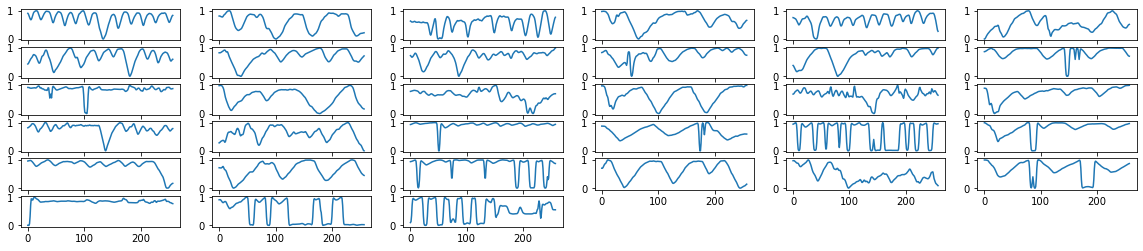

<Figure size 432x288 with 0 Axes>

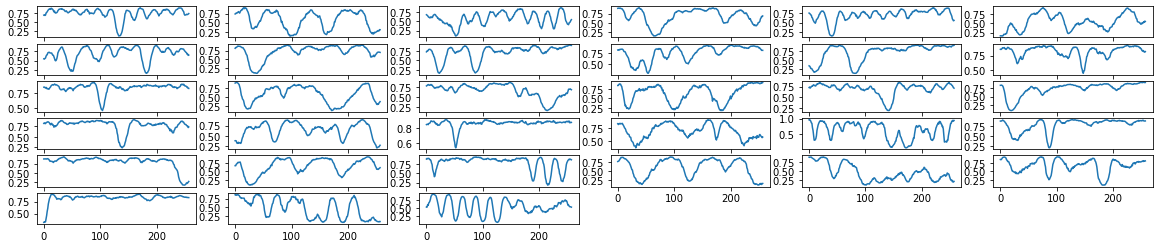

In [39]:
x2_pred = autoencoder2.predict(x2_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x2_pred[i])

Combine the encoder layer and the classification model:

In [40]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if i != ident]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    x2t_train = xt_train[:,1::step]
    x2t_train = np.apply_along_axis(convolve, 1, x2t_train)

    x2t_valid = xt_valid[:,1::step]
    x2t_valid = np.apply_along_axis(convolve, 1, x2t_valid)

    x2t_test = xt_test[:,1::step]
    x2t_test = np.apply_along_axis(convolve, 1, x2t_test)

    # AE Training
    batch_size = 256
    epochs = 100

    # this model maps an input to its reconstruction
    autoencoder2, encoded = sparse_ae(x2_train, 100)
    
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder2, x2t_train, x2t_train, batch_size, epochs,
                                           x2t_valid, x2t_valid, x2t_test, x2t_test)

    model = classifier(encoded)

    model = Model(inputs=autoencoder2.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, x2t_train, yt_train, batch_size, epochs,
                                           x2t_valid, yt_valid, x2t_test, yt_test)

    # This code remains from the previous author, copied from __main__()
    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()



AE TRAINING:  0
Train...
34/34 [==============================] - 0s 59us/sample - loss: 0.4904 - accuracy: 0.0071
Test score: 0.49041562673094286
Test accuracy: 0.007067943456452348


CLASSIFICATION TRAINING:  0
Train...
34/34 [==============================] - 0s 285us/sample - loss: 0.5820 - accuracy: 0.7059
Test score: 0.5820428880304285
Test accuracy: 0.7058823529411765


AE TRAINING:  1
Train...
36/36 [==============================] - 0s 83us/sample - loss: 0.5349 - accuracy: 0.0074
Test score: 0.5349409885625211
Test accuracy: 0.007428940568475453


CLASSIFICATION TRAINING:  1
Train...
36/36 [==============================] - 0s 222us/sample - loss: 0.6217 - accuracy: 0.6389
Test score: 0.6216826546426814
Test accuracy: 0.6388888888888888


AE TRAINING:  2
Train...
34/34 [==============================] - 0s 59us/sample - loss: 0.5928 - accuracy: 0.0074
Test score: 0.5927805416128388
Test accuracy: 0.007409940720474236


CLASSIFICATION TRAINING:  2
Train...
34/34 [===========

### Deep Autoencoders 

#### Deep Autoencoder - Normalized Input Data
from https://blog.keras.io/building-autoencoders-in-keras.html  
Just testing, still work in progress.

Build the autoencoder:

In [57]:
# From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
encoder_input = keras.Input(shape=x_train[0].shape, name="normalized_signal")
x = layers.Dropout(0.1, name="dropout", autocast=False)(encoder_input)
x = layers.Dense(512, activation="relu", name="dense_enc_1", autocast=False)(x)
x = layers.Dense(256, activation="relu", name="dense_enc_2")(x)
encoder_output = layers.Dense(64, activation="relu", name="encoded_signal")(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")

x = layers.Dense(256, activation="sigmoid", name="dense_dec_1")(encoder_output)
x = layers.Dense(512, activation="sigmoid", name="dense_dec_2")(x)
decoder_output = layers.Dense(x_train.shape[1], activation="sigmoid", name="reconstructed_signal")(x)
autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")

Print the summary of the autoencoder:

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalized_signal (InputLaye [(None, 1290)]            0         
_________________________________________________________________
dropout (Dropout)            (None, 1290)              0         
_________________________________________________________________
dense_enc_1 (Dense)          (None, 512)               660992    
_________________________________________________________________
dense_enc_2 (Dense)          (None, 256)               131328    
_________________________________________________________________
encoded_signal (Dense)       (None, 64)                16448     
_________________________________________________________________
dense_dec_1 (Dense)          (None, 256)               16640     
_________________________________________________________________
dense_dec_2 (Dense)          (None, 512)               

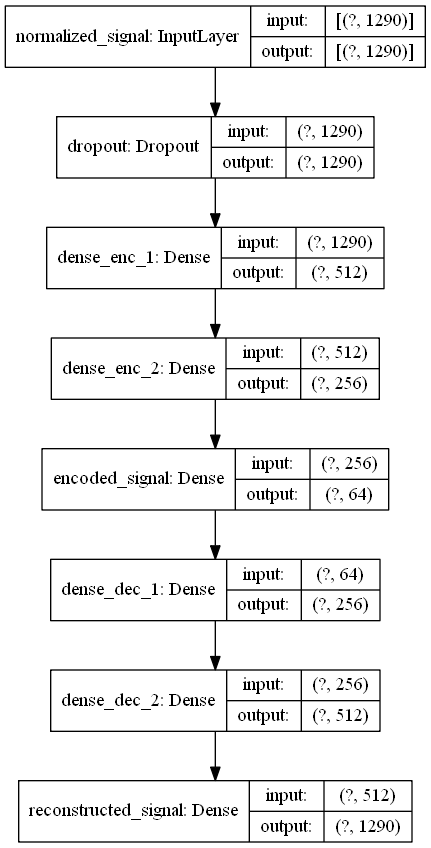

In [58]:
autoencoder.summary()
keras.utils.plot_model(autoencoder, "./AEOutput/deep_ae.png", show_shapes=True)

Compile and train the model:

In [59]:
# autoencoder.compile(optimizer='adam', loss='MSE')
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training
batch_size = 256
epochs = 5000

autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

# sc, curr_acc, epoch_data = model_train(autoencoder, x_train, x_train, batch_size, epochs, x_valid, x_valid, x_test, x_test)

Train on 722 samples, validate on 28 samples
Epoch 1/5000
722/722 [==============================] - 2s 2ms/sample - loss: 0.7019 - accuracy: 8.1599e-04 - val_loss: 0.6886 - val_accuracy: 7.1982e-04
Epoch 2/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.6953 - accuracy: 7.5694e-04 - val_loss: 0.6886 - val_accuracy: 8.0288e-04
Epoch 3/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.6945 - accuracy: 7.6875e-04 - val_loss: 0.6904 - val_accuracy: 7.4751e-04
Epoch 4/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.6927 - accuracy: 7.6446e-04 - val_loss: 0.6870 - val_accuracy: 8.0288e-04
Epoch 5/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.6909 - accuracy: 7.8378e-04 - val_loss: 0.6833 - val_accuracy: 8.5825e-04
Epoch 6/5000
722/722 [==============================] - 0s 363us/sample - loss: 0.6890 - accuracy: 8.2244e-04 - val_loss: 0.6799 - val_accuracy: 8.3056e-04
Epoch 7/5000
722/722 

Epoch 53/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.6146 - accuracy: 8.1707e-04 - val_loss: 0.5990 - val_accuracy: 8.0288e-04
Epoch 54/5000
722/722 [==============================] - 0s 351us/sample - loss: 0.6138 - accuracy: 8.2888e-04 - val_loss: 0.5975 - val_accuracy: 7.7519e-04
Epoch 55/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.6114 - accuracy: 8.4176e-04 - val_loss: 0.5977 - val_accuracy: 8.3056e-04
Epoch 56/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.6102 - accuracy: 8.4928e-04 - val_loss: 0.5970 - val_accuracy: 8.0288e-04
Epoch 57/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.6091 - accuracy: 8.7075e-04 - val_loss: 0.5960 - val_accuracy: 7.7519e-04
Epoch 58/5000
722/722 [==============================] - 0s 344us/sample - loss: 0.6083 - accuracy: 8.6431e-04 - val_loss: 0.5954 - val_accuracy: 8.0288e-04
Epoch 59/5000
722/722 [==============================] - 0

Epoch 157/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5917 - accuracy: 0.0010 - val_loss: 0.5879 - val_accuracy: 9.1362e-04
Epoch 158/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5911 - accuracy: 0.0010 - val_loss: 0.5874 - val_accuracy: 9.4131e-04
Epoch 159/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5905 - accuracy: 9.9852e-04 - val_loss: 0.5877 - val_accuracy: 9.4131e-04
Epoch 160/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5904 - accuracy: 9.9637e-04 - val_loss: 0.5869 - val_accuracy: 9.1362e-04
Epoch 161/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5899 - accuracy: 0.0010 - val_loss: 0.5870 - val_accuracy: 9.1362e-04
Epoch 162/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5896 - accuracy: 0.0010 - val_loss: 0.5868 - val_accuracy: 9.4131e-04
Epoch 163/5000
722/722 [==============================] - 0s 340us/s

722/722 [==============================] - 0s 333us/sample - loss: 0.5689 - accuracy: 0.0011 - val_loss: 0.5797 - val_accuracy: 9.4131e-04
Epoch 264/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5683 - accuracy: 0.0011 - val_loss: 0.5800 - val_accuracy: 9.4131e-04
Epoch 265/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5682 - accuracy: 0.0011 - val_loss: 0.5801 - val_accuracy: 9.4131e-04
Epoch 266/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5680 - accuracy: 0.0011 - val_loss: 0.5802 - val_accuracy: 9.4131e-04
Epoch 267/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5680 - accuracy: 0.0011 - val_loss: 0.5801 - val_accuracy: 9.4131e-04
Epoch 268/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5681 - accuracy: 0.0011 - val_loss: 0.5801 - val_accuracy: 9.1362e-04
Epoch 269/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5677 - 

722/722 [==============================] - 0s 337us/sample - loss: 0.5527 - accuracy: 0.0012 - val_loss: 0.5767 - val_accuracy: 9.6899e-04
Epoch 370/5000
722/722 [==============================] - 0s 344us/sample - loss: 0.5525 - accuracy: 0.0012 - val_loss: 0.5771 - val_accuracy: 9.9668e-04
Epoch 371/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5530 - accuracy: 0.0012 - val_loss: 0.5763 - val_accuracy: 9.9668e-04
Epoch 372/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5525 - accuracy: 0.0012 - val_loss: 0.5772 - val_accuracy: 9.6899e-04
Epoch 373/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5526 - accuracy: 0.0012 - val_loss: 0.5769 - val_accuracy: 9.6899e-04
Epoch 374/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5525 - accuracy: 0.0012 - val_loss: 0.5763 - val_accuracy: 9.9668e-04
Epoch 375/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5517 - 

Epoch 423/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5457 - accuracy: 0.0012 - val_loss: 0.5742 - val_accuracy: 9.9668e-04
Epoch 424/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5459 - accuracy: 0.0012 - val_loss: 0.5741 - val_accuracy: 9.9668e-04
Epoch 425/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5457 - accuracy: 0.0012 - val_loss: 0.5741 - val_accuracy: 0.0010
Epoch 426/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5456 - accuracy: 0.0012 - val_loss: 0.5740 - val_accuracy: 0.0010
Epoch 427/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5457 - accuracy: 0.0012 - val_loss: 0.5745 - val_accuracy: 9.9668e-04
Epoch 428/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5457 - accuracy: 0.0012 - val_loss: 0.5745 - val_accuracy: 9.9668e-04
Epoch 429/5000
722/722 [==============================] - 0s 326us/sample - loss: 0.

722/722 [==============================] - 0s 340us/sample - loss: 0.5361 - accuracy: 0.0013 - val_loss: 0.5715 - val_accuracy: 9.9668e-04
Epoch 530/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5360 - accuracy: 0.0013 - val_loss: 0.5718 - val_accuracy: 9.9668e-04
Epoch 531/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5360 - accuracy: 0.0013 - val_loss: 0.5717 - val_accuracy: 0.0010
Epoch 532/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5361 - accuracy: 0.0013 - val_loss: 0.5716 - val_accuracy: 0.0010
Epoch 533/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5362 - accuracy: 0.0012 - val_loss: 0.5716 - val_accuracy: 9.9668e-04
Epoch 534/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5362 - accuracy: 0.0013 - val_loss: 0.5717 - val_accuracy: 9.9668e-04
Epoch 535/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5363 - accuracy

722/722 [==============================] - 0s 344us/sample - loss: 0.5300 - accuracy: 0.0013 - val_loss: 0.5703 - val_accuracy: 0.0010
Epoch 636/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5300 - accuracy: 0.0013 - val_loss: 0.5704 - val_accuracy: 9.9668e-04
Epoch 637/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5301 - accuracy: 0.0013 - val_loss: 0.5695 - val_accuracy: 9.9668e-04
Epoch 638/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5297 - accuracy: 0.0013 - val_loss: 0.5695 - val_accuracy: 9.9668e-04
Epoch 639/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5296 - accuracy: 0.0013 - val_loss: 0.5697 - val_accuracy: 9.9668e-04
Epoch 640/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5296 - accuracy: 0.0013 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 641/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5296 - accuracy

Epoch 689/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5273 - accuracy: 0.0013 - val_loss: 0.5691 - val_accuracy: 9.9668e-04
Epoch 690/5000
722/722 [==============================] - 0s 344us/sample - loss: 0.5273 - accuracy: 0.0013 - val_loss: 0.5689 - val_accuracy: 9.9668e-04
Epoch 691/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5273 - accuracy: 0.0013 - val_loss: 0.5692 - val_accuracy: 9.9668e-04
Epoch 692/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5276 - accuracy: 0.0013 - val_loss: 0.5693 - val_accuracy: 9.9668e-04
Epoch 693/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5275 - accuracy: 0.0013 - val_loss: 0.5692 - val_accuracy: 9.9668e-04
Epoch 694/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5273 - accuracy: 0.0013 - val_loss: 0.5698 - val_accuracy: 0.0010
Epoch 695/5000
722/722 [==============================] - 0s 338us/sample - loss

Epoch 743/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5255 - accuracy: 0.0013 - val_loss: 0.5692 - val_accuracy: 9.9668e-04
Epoch 744/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5256 - accuracy: 0.0013 - val_loss: 0.5691 - val_accuracy: 9.9668e-04
Epoch 745/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5261 - accuracy: 0.0013 - val_loss: 0.5694 - val_accuracy: 0.0010
Epoch 746/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5254 - accuracy: 0.0013 - val_loss: 0.5691 - val_accuracy: 0.0010
Epoch 747/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5254 - accuracy: 0.0013 - val_loss: 0.5695 - val_accuracy: 9.9668e-04
Epoch 748/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5255 - accuracy: 0.0013 - val_loss: 0.5689 - val_accuracy: 9.9668e-04
Epoch 749/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.

722/722 [==============================] - 0s 347us/sample - loss: 0.5224 - accuracy: 0.0013 - val_loss: 0.5684 - val_accuracy: 0.0010
Epoch 850/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5223 - accuracy: 0.0013 - val_loss: 0.5685 - val_accuracy: 9.9668e-04
Epoch 851/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5224 - accuracy: 0.0013 - val_loss: 0.5687 - val_accuracy: 0.0010
Epoch 852/5000
722/722 [==============================] - 0s 325us/sample - loss: 0.5225 - accuracy: 0.0013 - val_loss: 0.5685 - val_accuracy: 0.0010
Epoch 853/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5223 - accuracy: 0.0013 - val_loss: 0.5682 - val_accuracy: 0.0011
Epoch 854/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5222 - accuracy: 0.0013 - val_loss: 0.5682 - val_accuracy: 0.0010
Epoch 855/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5221 - accuracy: 0.0013 - v

Epoch 957/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5199 - accuracy: 0.0013 - val_loss: 0.5685 - val_accuracy: 0.0010
Epoch 958/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5199 - accuracy: 0.0013 - val_loss: 0.5682 - val_accuracy: 0.0010
Epoch 959/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5198 - accuracy: 0.0013 - val_loss: 0.5683 - val_accuracy: 0.0010
Epoch 960/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5198 - accuracy: 0.0013 - val_loss: 0.5681 - val_accuracy: 0.0010
Epoch 961/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5198 - accuracy: 0.0013 - val_loss: 0.5678 - val_accuracy: 0.0010
Epoch 962/5000
722/722 [==============================] - 0s 326us/sample - loss: 0.5198 - accuracy: 0.0013 - val_loss: 0.5682 - val_accuracy: 0.0010
Epoch 963/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5200 - accuracy:

722/722 [==============================] - 0s 336us/sample - loss: 0.5178 - accuracy: 0.0013 - val_loss: 0.5681 - val_accuracy: 0.0010
Epoch 1066/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5178 - accuracy: 0.0013 - val_loss: 0.5681 - val_accuracy: 0.0011
Epoch 1067/5000
722/722 [==============================] - 0s 325us/sample - loss: 0.5177 - accuracy: 0.0013 - val_loss: 0.5687 - val_accuracy: 0.0010
Epoch 1068/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5178 - accuracy: 0.0013 - val_loss: 0.5685 - val_accuracy: 0.0010
Epoch 1069/5000
722/722 [==============================] - 0s 351us/sample - loss: 0.5177 - accuracy: 0.0013 - val_loss: 0.5682 - val_accuracy: 0.0010
Epoch 1070/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5177 - accuracy: 0.0013 - val_loss: 0.5684 - val_accuracy: 0.0011
Epoch 1071/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5177 - accuracy: 0.0013 -

722/722 [==============================] - 0s 337us/sample - loss: 0.5160 - accuracy: 0.0013 - val_loss: 0.5680 - val_accuracy: 0.0011
Epoch 1174/5000
722/722 [==============================] - 0s 355us/sample - loss: 0.5158 - accuracy: 0.0013 - val_loss: 0.5682 - val_accuracy: 0.0011
Epoch 1175/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5158 - accuracy: 0.0013 - val_loss: 0.5683 - val_accuracy: 0.0010
Epoch 1176/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5160 - accuracy: 0.0013 - val_loss: 0.5680 - val_accuracy: 0.0011
Epoch 1177/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5158 - accuracy: 0.0013 - val_loss: 0.5681 - val_accuracy: 0.0011
Epoch 1178/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5159 - accuracy: 0.0013 - val_loss: 0.5680 - val_accuracy: 0.0011
Epoch 1179/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5157 - accuracy: 0.0013 -

722/722 [==============================] - 0s 337us/sample - loss: 0.5145 - accuracy: 0.0013 - val_loss: 0.5679 - val_accuracy: 0.0011
Epoch 1282/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5144 - accuracy: 0.0013 - val_loss: 0.5678 - val_accuracy: 0.0010
Epoch 1283/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5144 - accuracy: 0.0013 - val_loss: 0.5680 - val_accuracy: 0.0011
Epoch 1284/5000
722/722 [==============================] - 0s 351us/sample - loss: 0.5144 - accuracy: 0.0013 - val_loss: 0.5681 - val_accuracy: 0.0011
Epoch 1285/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5144 - accuracy: 0.0013 - val_loss: 0.5680 - val_accuracy: 0.0010
Epoch 1286/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5143 - accuracy: 0.0013 - val_loss: 0.5680 - val_accuracy: 0.0011
Epoch 1287/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5143 - accuracy: 0.0013 -

722/722 [==============================] - 0s 336us/sample - loss: 0.5132 - accuracy: 0.0014 - val_loss: 0.5683 - val_accuracy: 0.0010
Epoch 1390/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5133 - accuracy: 0.0014 - val_loss: 0.5683 - val_accuracy: 0.0010
Epoch 1391/5000
722/722 [==============================] - 0s 344us/sample - loss: 0.5133 - accuracy: 0.0013 - val_loss: 0.5681 - val_accuracy: 0.0010
Epoch 1392/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5133 - accuracy: 0.0013 - val_loss: 0.5683 - val_accuracy: 0.0010
Epoch 1393/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5133 - accuracy: 0.0014 - val_loss: 0.5682 - val_accuracy: 0.0010
Epoch 1394/5000
722/722 [==============================] - 0s 344us/sample - loss: 0.5134 - accuracy: 0.0014 - val_loss: 0.5684 - val_accuracy: 0.0011
Epoch 1395/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5132 - accuracy: 0.0013 -

722/722 [==============================] - 0s 337us/sample - loss: 0.5121 - accuracy: 0.0014 - val_loss: 0.5676 - val_accuracy: 0.0011
Epoch 1498/5000
722/722 [==============================] - 0s 361us/sample - loss: 0.5121 - accuracy: 0.0014 - val_loss: 0.5679 - val_accuracy: 0.0010
Epoch 1499/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5120 - accuracy: 0.0014 - val_loss: 0.5684 - val_accuracy: 0.0010
Epoch 1500/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5121 - accuracy: 0.0014 - val_loss: 0.5684 - val_accuracy: 9.9668e-04
Epoch 1501/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5120 - accuracy: 0.0014 - val_loss: 0.5685 - val_accuracy: 0.0010
Epoch 1502/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5121 - accuracy: 0.0014 - val_loss: 0.5684 - val_accuracy: 0.0010
Epoch 1503/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5120 - accuracy: 0.00

Epoch 1551/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5115 - accuracy: 0.0014 - val_loss: 0.5687 - val_accuracy: 0.0010
Epoch 1552/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5115 - accuracy: 0.0014 - val_loss: 0.5687 - val_accuracy: 0.0010
Epoch 1553/5000
722/722 [==============================] - 0s 390us/sample - loss: 0.5115 - accuracy: 0.0014 - val_loss: 0.5683 - val_accuracy: 0.0010
Epoch 1554/5000
722/722 [==============================] - 0s 373us/sample - loss: 0.5114 - accuracy: 0.0014 - val_loss: 0.5681 - val_accuracy: 0.0010
Epoch 1555/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5115 - accuracy: 0.0014 - val_loss: 0.5684 - val_accuracy: 9.9668e-04
Epoch 1556/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5115 - accuracy: 0.0014 - val_loss: 0.5686 - val_accuracy: 9.9668e-04
Epoch 1557/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5

722/722 [==============================] - 0s 334us/sample - loss: 0.5110 - accuracy: 0.0014 - val_loss: 0.5683 - val_accuracy: 9.9668e-04
Epoch 1658/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5111 - accuracy: 0.0014 - val_loss: 0.5689 - val_accuracy: 9.9668e-04
Epoch 1659/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5111 - accuracy: 0.0014 - val_loss: 0.5694 - val_accuracy: 9.9668e-04
Epoch 1660/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5113 - accuracy: 0.0014 - val_loss: 0.5699 - val_accuracy: 0.0010
Epoch 1661/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5112 - accuracy: 0.0014 - val_loss: 0.5695 - val_accuracy: 9.9668e-04
Epoch 1662/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5110 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 9.9668e-04
Epoch 1663/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5110 

722/722 [==============================] - 0s 337us/sample - loss: 0.5098 - accuracy: 0.0014 - val_loss: 0.5692 - val_accuracy: 9.6899e-04
Epoch 1764/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5099 - accuracy: 0.0014 - val_loss: 0.5690 - val_accuracy: 9.9668e-04
Epoch 1765/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5098 - accuracy: 0.0014 - val_loss: 0.5688 - val_accuracy: 9.9668e-04
Epoch 1766/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5099 - accuracy: 0.0014 - val_loss: 0.5688 - val_accuracy: 9.9668e-04
Epoch 1767/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5098 - accuracy: 0.0014 - val_loss: 0.5692 - val_accuracy: 0.0010
Epoch 1768/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5098 - accuracy: 0.0014 - val_loss: 0.5692 - val_accuracy: 9.9668e-04
Epoch 1769/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5098 

722/722 [==============================] - 0s 349us/sample - loss: 0.5091 - accuracy: 0.0014 - val_loss: 0.5682 - val_accuracy: 9.9668e-04
Epoch 1870/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5091 - accuracy: 0.0014 - val_loss: 0.5683 - val_accuracy: 9.9668e-04
Epoch 1871/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5090 - accuracy: 0.0014 - val_loss: 0.5683 - val_accuracy: 0.0010
Epoch 1872/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5090 - accuracy: 0.0014 - val_loss: 0.5685 - val_accuracy: 9.9668e-04
Epoch 1873/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5090 - accuracy: 0.0014 - val_loss: 0.5683 - val_accuracy: 9.9668e-04
Epoch 1874/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5090 - accuracy: 0.0014 - val_loss: 0.5686 - val_accuracy: 9.9668e-04
Epoch 1875/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5090 

722/722 [==============================] - 0s 337us/sample - loss: 0.5088 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 0.0010
Epoch 1976/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5088 - accuracy: 0.0014 - val_loss: 0.5692 - val_accuracy: 9.9668e-04
Epoch 1977/5000
722/722 [==============================] - 0s 325us/sample - loss: 0.5087 - accuracy: 0.0014 - val_loss: 0.5690 - val_accuracy: 0.0010
Epoch 1978/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5086 - accuracy: 0.0014 - val_loss: 0.5692 - val_accuracy: 9.9668e-04
Epoch 1979/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5088 - accuracy: 0.0014 - val_loss: 0.5691 - val_accuracy: 0.0010
Epoch 1980/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5087 - accuracy: 0.0014 - val_loss: 0.5691 - val_accuracy: 0.0010
Epoch 1981/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5087 - accuracy: 

Epoch 2082/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5078 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 0.0010
Epoch 2083/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5079 - accuracy: 0.0014 - val_loss: 0.5696 - val_accuracy: 0.0010
Epoch 2084/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5081 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 9.9668e-04
Epoch 2085/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5080 - accuracy: 0.0014 - val_loss: 0.5694 - val_accuracy: 0.0010
Epoch 2086/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5079 - accuracy: 0.0014 - val_loss: 0.5699 - val_accuracy: 9.6899e-04
Epoch 2087/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5079 - accuracy: 0.0014 - val_loss: 0.5696 - val_accuracy: 0.0010
Epoch 2088/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5

Epoch 2136/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5075 - accuracy: 0.0014 - val_loss: 0.5691 - val_accuracy: 0.0010
Epoch 2137/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5075 - accuracy: 0.0014 - val_loss: 0.5690 - val_accuracy: 0.0010
Epoch 2138/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5075 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 0.0010
Epoch 2139/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5075 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 9.9668e-04
Epoch 2140/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5076 - accuracy: 0.0014 - val_loss: 0.5698 - val_accuracy: 0.0010
Epoch 2141/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5078 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2142/5000
722/722 [==============================] - 0s 325us/sample - loss: 0.5076 

Epoch 2190/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5073 - accuracy: 0.0014 - val_loss: 0.5694 - val_accuracy: 0.0010
Epoch 2191/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5073 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 0.0010
Epoch 2192/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5073 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2193/5000
722/722 [==============================] - 0s 326us/sample - loss: 0.5073 - accuracy: 0.0014 - val_loss: 0.5695 - val_accuracy: 0.0010
Epoch 2194/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5072 - accuracy: 0.0014 - val_loss: 0.5693 - val_accuracy: 0.0010
Epoch 2195/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5072 - accuracy: 0.0014 - val_loss: 0.5691 - val_accuracy: 9.9668e-04
Epoch 2196/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5071 

Epoch 2244/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5070 - accuracy: 0.0014 - val_loss: 0.5692 - val_accuracy: 0.0010
Epoch 2245/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5070 - accuracy: 0.0014 - val_loss: 0.5694 - val_accuracy: 9.9668e-04
Epoch 2246/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5069 - accuracy: 0.0014 - val_loss: 0.5696 - val_accuracy: 0.0010
Epoch 2247/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5070 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 9.9668e-04
Epoch 2248/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5069 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 9.9668e-04
Epoch 2249/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5069 - accuracy: 0.0014 - val_loss: 0.5695 - val_accuracy: 0.0010
Epoch 2250/5000
722/722 [==============================] - 0s 333us/sample - loss:

Epoch 2298/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5068 - accuracy: 0.0014 - val_loss: 0.5699 - val_accuracy: 0.0010
Epoch 2299/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5068 - accuracy: 0.0014 - val_loss: 0.5700 - val_accuracy: 0.0010
Epoch 2300/5000
722/722 [==============================] - 0s 363us/sample - loss: 0.5068 - accuracy: 0.0014 - val_loss: 0.5701 - val_accuracy: 0.0010
Epoch 2301/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5071 - accuracy: 0.0014 - val_loss: 0.5698 - val_accuracy: 0.0010
Epoch 2302/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5067 - accuracy: 0.0014 - val_loss: 0.5698 - val_accuracy: 0.0010
Epoch 2303/5000
722/722 [==============================] - 0s 326us/sample - loss: 0.5067 - accuracy: 0.0014 - val_loss: 0.5699 - val_accuracy: 0.0010
Epoch 2304/5000
722/722 [==============================] - 0s 351us/sample - loss: 0.5070 - ac

Epoch 2352/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5064 - accuracy: 0.0014 - val_loss: 0.5703 - val_accuracy: 0.0010
Epoch 2353/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5065 - accuracy: 0.0014 - val_loss: 0.5702 - val_accuracy: 0.0010
Epoch 2354/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5064 - accuracy: 0.0014 - val_loss: 0.5696 - val_accuracy: 9.9668e-04
Epoch 2355/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5065 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2356/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5064 - accuracy: 0.0014 - val_loss: 0.5700 - val_accuracy: 0.0010
Epoch 2357/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5064 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2358/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5064 

722/722 [==============================] - 0s 348us/sample - loss: 0.5062 - accuracy: 0.0014 - val_loss: 0.5701 - val_accuracy: 9.9668e-04
Epoch 2407/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5062 - accuracy: 0.0014 - val_loss: 0.5694 - val_accuracy: 0.0010
Epoch 2408/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5061 - accuracy: 0.0014 - val_loss: 0.5692 - val_accuracy: 0.0010
Epoch 2409/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5062 - accuracy: 0.0014 - val_loss: 0.5695 - val_accuracy: 0.0010
Epoch 2410/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5062 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 9.9668e-04
Epoch 2411/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5064 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2412/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5063 - accuracy: 

Epoch 2460/5000
722/722 [==============================] - 0s 354us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2461/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5699 - val_accuracy: 0.0010
Epoch 2462/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5703 - val_accuracy: 0.0010
Epoch 2463/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5703 - val_accuracy: 0.0010
Epoch 2464/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5704 - val_accuracy: 0.0010
Epoch 2465/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5702 - val_accuracy: 0.0010
Epoch 2466/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5060 - ac

Epoch 2514/5000
722/722 [==============================] - 0s 326us/sample - loss: 0.5059 - accuracy: 0.0014 - val_loss: 0.5701 - val_accuracy: 0.0010
Epoch 2515/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5059 - accuracy: 0.0014 - val_loss: 0.5699 - val_accuracy: 0.0010
Epoch 2516/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5059 - accuracy: 0.0014 - val_loss: 0.5700 - val_accuracy: 0.0010
Epoch 2517/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5059 - accuracy: 0.0014 - val_loss: 0.5700 - val_accuracy: 9.9668e-04
Epoch 2518/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5699 - val_accuracy: 0.0010
Epoch 2519/5000
722/722 [==============================] - 0s 320us/sample - loss: 0.5060 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2520/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5058 

722/722 [==============================] - 0s 441us/sample - loss: 0.5053 - accuracy: 0.0014 - val_loss: 0.5703 - val_accuracy: 0.0010
Epoch 2623/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5054 - accuracy: 0.0014 - val_loss: 0.5701 - val_accuracy: 0.0010
Epoch 2624/5000
722/722 [==============================] - 0s 354us/sample - loss: 0.5054 - accuracy: 0.0014 - val_loss: 0.5700 - val_accuracy: 0.0010
Epoch 2625/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5053 - accuracy: 0.0014 - val_loss: 0.5702 - val_accuracy: 0.0010
Epoch 2626/5000
722/722 [==============================] - 0s 356us/sample - loss: 0.5053 - accuracy: 0.0014 - val_loss: 0.5700 - val_accuracy: 0.0010
Epoch 2627/5000
722/722 [==============================] - 0s 352us/sample - loss: 0.5053 - accuracy: 0.0014 - val_loss: 0.5697 - val_accuracy: 0.0010
Epoch 2628/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5053 - accuracy: 0.0014 -

722/722 [==============================] - 0s 367us/sample - loss: 0.5050 - accuracy: 0.0014 - val_loss: 0.5703 - val_accuracy: 0.0010
Epoch 2731/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5050 - accuracy: 0.0014 - val_loss: 0.5704 - val_accuracy: 0.0010
Epoch 2732/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5050 - accuracy: 0.0014 - val_loss: 0.5702 - val_accuracy: 0.0010
Epoch 2733/5000
722/722 [==============================] - 0s 383us/sample - loss: 0.5049 - accuracy: 0.0014 - val_loss: 0.5700 - val_accuracy: 0.0010
Epoch 2734/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5050 - accuracy: 0.0014 - val_loss: 0.5705 - val_accuracy: 0.0010
Epoch 2735/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5050 - accuracy: 0.0014 - val_loss: 0.5708 - val_accuracy: 0.0010
Epoch 2736/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5050 - accuracy: 0.0014 -

722/722 [==============================] - 0s 347us/sample - loss: 0.5047 - accuracy: 0.0014 - val_loss: 0.5706 - val_accuracy: 0.0010
Epoch 2839/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5047 - accuracy: 0.0014 - val_loss: 0.5707 - val_accuracy: 0.0010
Epoch 2840/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5047 - accuracy: 0.0014 - val_loss: 0.5712 - val_accuracy: 0.0010
Epoch 2841/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5047 - accuracy: 0.0014 - val_loss: 0.5713 - val_accuracy: 0.0010
Epoch 2842/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5046 - accuracy: 0.0014 - val_loss: 0.5716 - val_accuracy: 0.0010
Epoch 2843/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5047 - accuracy: 0.0014 - val_loss: 0.5712 - val_accuracy: 0.0010
Epoch 2844/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5048 - accuracy: 0.0014 -

722/722 [==============================] - 0s 334us/sample - loss: 0.5044 - accuracy: 0.0014 - val_loss: 0.5706 - val_accuracy: 0.0010
Epoch 2947/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5043 - accuracy: 0.0014 - val_loss: 0.5708 - val_accuracy: 0.0010
Epoch 2948/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5044 - accuracy: 0.0014 - val_loss: 0.5713 - val_accuracy: 0.0010
Epoch 2949/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5044 - accuracy: 0.0014 - val_loss: 0.5718 - val_accuracy: 0.0010
Epoch 2950/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5045 - accuracy: 0.0014 - val_loss: 0.5714 - val_accuracy: 0.0010
Epoch 2951/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5043 - accuracy: 0.0014 - val_loss: 0.5708 - val_accuracy: 0.0010
Epoch 2952/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5043 - accuracy: 0.0014 -

722/722 [==============================] - 0s 347us/sample - loss: 0.5041 - accuracy: 0.0014 - val_loss: 0.5713 - val_accuracy: 0.0010
Epoch 3055/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5041 - accuracy: 0.0014 - val_loss: 0.5715 - val_accuracy: 0.0010
Epoch 3056/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5041 - accuracy: 0.0014 - val_loss: 0.5712 - val_accuracy: 0.0010
Epoch 3057/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5040 - accuracy: 0.0014 - val_loss: 0.5711 - val_accuracy: 0.0010
Epoch 3058/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5041 - accuracy: 0.0014 - val_loss: 0.5708 - val_accuracy: 0.0010
Epoch 3059/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5041 - accuracy: 0.0014 - val_loss: 0.5709 - val_accuracy: 0.0010
Epoch 3060/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5040 - accuracy: 0.0014 -

722/722 [==============================] - 0s 336us/sample - loss: 0.5039 - accuracy: 0.0014 - val_loss: 0.5715 - val_accuracy: 0.0010
Epoch 3163/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5038 - accuracy: 0.0014 - val_loss: 0.5714 - val_accuracy: 0.0010
Epoch 3164/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5038 - accuracy: 0.0014 - val_loss: 0.5716 - val_accuracy: 0.0010
Epoch 3165/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5039 - accuracy: 0.0014 - val_loss: 0.5715 - val_accuracy: 0.0010
Epoch 3166/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5038 - accuracy: 0.0014 - val_loss: 0.5716 - val_accuracy: 0.0010
Epoch 3167/5000
722/722 [==============================] - 0s 325us/sample - loss: 0.5038 - accuracy: 0.0014 - val_loss: 0.5713 - val_accuracy: 0.0010
Epoch 3168/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5037 - accuracy: 0.0014 -

722/722 [==============================] - 0s 345us/sample - loss: 0.5035 - accuracy: 0.0014 - val_loss: 0.5714 - val_accuracy: 0.0010
Epoch 3271/5000
722/722 [==============================] - 0s 370us/sample - loss: 0.5035 - accuracy: 0.0014 - val_loss: 0.5716 - val_accuracy: 0.0010
Epoch 3272/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5035 - accuracy: 0.0015 - val_loss: 0.5720 - val_accuracy: 0.0010
Epoch 3273/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5036 - accuracy: 0.0014 - val_loss: 0.5726 - val_accuracy: 0.0010
Epoch 3274/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5037 - accuracy: 0.0014 - val_loss: 0.5720 - val_accuracy: 0.0010
Epoch 3275/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5037 - accuracy: 0.0014 - val_loss: 0.5718 - val_accuracy: 0.0010
Epoch 3276/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5036 - accuracy: 0.0014 -

722/722 [==============================] - 0s 340us/sample - loss: 0.5036 - accuracy: 0.0014 - val_loss: 0.5721 - val_accuracy: 0.0010
Epoch 3379/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5034 - accuracy: 0.0014 - val_loss: 0.5724 - val_accuracy: 0.0010
Epoch 3380/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5033 - accuracy: 0.0014 - val_loss: 0.5721 - val_accuracy: 0.0010
Epoch 3381/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5034 - accuracy: 0.0015 - val_loss: 0.5724 - val_accuracy: 0.0010
Epoch 3382/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5033 - accuracy: 0.0014 - val_loss: 0.5727 - val_accuracy: 0.0010
Epoch 3383/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5034 - accuracy: 0.0014 - val_loss: 0.5715 - val_accuracy: 0.0010
Epoch 3384/5000
722/722 [==============================] - 0s 345us/sample - loss: 0.5032 - accuracy: 0.0014 -

722/722 [==============================] - 0s 337us/sample - loss: 0.5030 - accuracy: 0.0015 - val_loss: 0.5720 - val_accuracy: 0.0010
Epoch 3487/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5030 - accuracy: 0.0014 - val_loss: 0.5718 - val_accuracy: 0.0010
Epoch 3488/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5030 - accuracy: 0.0014 - val_loss: 0.5724 - val_accuracy: 0.0010
Epoch 3489/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5030 - accuracy: 0.0014 - val_loss: 0.5725 - val_accuracy: 0.0010
Epoch 3490/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5030 - accuracy: 0.0014 - val_loss: 0.5724 - val_accuracy: 0.0010
Epoch 3491/5000
722/722 [==============================] - 0s 365us/sample - loss: 0.5030 - accuracy: 0.0014 - val_loss: 0.5724 - val_accuracy: 0.0010
Epoch 3492/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5029 - accuracy: 0.0015 -

722/722 [==============================] - 0s 334us/sample - loss: 0.5030 - accuracy: 0.0015 - val_loss: 0.5721 - val_accuracy: 0.0010
Epoch 3595/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5030 - accuracy: 0.0014 - val_loss: 0.5723 - val_accuracy: 0.0010
Epoch 3596/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5031 - accuracy: 0.0014 - val_loss: 0.5723 - val_accuracy: 0.0010
Epoch 3597/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5029 - accuracy: 0.0015 - val_loss: 0.5726 - val_accuracy: 0.0010
Epoch 3598/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5030 - accuracy: 0.0015 - val_loss: 0.5723 - val_accuracy: 0.0010
Epoch 3599/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5029 - accuracy: 0.0014 - val_loss: 0.5720 - val_accuracy: 0.0010
Epoch 3600/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5028 - accuracy: 0.0015 -

722/722 [==============================] - 0s 337us/sample - loss: 0.5027 - accuracy: 0.0015 - val_loss: 0.5730 - val_accuracy: 0.0010
Epoch 3703/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5026 - accuracy: 0.0015 - val_loss: 0.5727 - val_accuracy: 0.0010
Epoch 3704/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5027 - accuracy: 0.0015 - val_loss: 0.5725 - val_accuracy: 0.0010
Epoch 3705/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5026 - accuracy: 0.0015 - val_loss: 0.5723 - val_accuracy: 0.0010
Epoch 3706/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5026 - accuracy: 0.0015 - val_loss: 0.5722 - val_accuracy: 0.0010
Epoch 3707/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5026 - accuracy: 0.0015 - val_loss: 0.5721 - val_accuracy: 0.0010
Epoch 3708/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5028 - accuracy: 0.0015 -

722/722 [==============================] - 0s 340us/sample - loss: 0.5025 - accuracy: 0.0015 - val_loss: 0.5727 - val_accuracy: 0.0010
Epoch 3811/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5024 - accuracy: 0.0015 - val_loss: 0.5731 - val_accuracy: 0.0010
Epoch 3812/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5025 - accuracy: 0.0015 - val_loss: 0.5726 - val_accuracy: 0.0010
Epoch 3813/5000
722/722 [==============================] - 0s 323us/sample - loss: 0.5024 - accuracy: 0.0015 - val_loss: 0.5729 - val_accuracy: 0.0010
Epoch 3814/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5024 - accuracy: 0.0015 - val_loss: 0.5726 - val_accuracy: 0.0010
Epoch 3815/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5024 - accuracy: 0.0015 - val_loss: 0.5726 - val_accuracy: 0.0010
Epoch 3816/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5024 - accuracy: 0.0015 -

722/722 [==============================] - 0s 327us/sample - loss: 0.5023 - accuracy: 0.0015 - val_loss: 0.5738 - val_accuracy: 9.9668e-04
Epoch 3919/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5022 - accuracy: 0.0015 - val_loss: 0.5731 - val_accuracy: 9.9668e-04
Epoch 3920/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5023 - accuracy: 0.0015 - val_loss: 0.5729 - val_accuracy: 0.0010
Epoch 3921/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5023 - accuracy: 0.0015 - val_loss: 0.5728 - val_accuracy: 0.0010
Epoch 3922/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5023 - accuracy: 0.0015 - val_loss: 0.5726 - val_accuracy: 0.0010
Epoch 3923/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5023 - accuracy: 0.0015 - val_loss: 0.5727 - val_accuracy: 0.0010
Epoch 3924/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5023 - accuracy: 

722/722 [==============================] - 0s 332us/sample - loss: 0.5021 - accuracy: 0.0015 - val_loss: 0.5733 - val_accuracy: 0.0010
Epoch 4027/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5021 - accuracy: 0.0015 - val_loss: 0.5733 - val_accuracy: 0.0010
Epoch 4028/5000
722/722 [==============================] - 0s 348us/sample - loss: 0.5021 - accuracy: 0.0015 - val_loss: 0.5731 - val_accuracy: 0.0010
Epoch 4029/5000
722/722 [==============================] - 0s 349us/sample - loss: 0.5020 - accuracy: 0.0015 - val_loss: 0.5731 - val_accuracy: 0.0010
Epoch 4030/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5021 - accuracy: 0.0015 - val_loss: 0.5736 - val_accuracy: 0.0010
Epoch 4031/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5021 - accuracy: 0.0015 - val_loss: 0.5741 - val_accuracy: 0.0010
Epoch 4032/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5021 - accuracy: 0.0015 -

722/722 [==============================] - 0s 338us/sample - loss: 0.5019 - accuracy: 0.0015 - val_loss: 0.5743 - val_accuracy: 0.0010
Epoch 4135/5000
722/722 [==============================] - 0s 322us/sample - loss: 0.5019 - accuracy: 0.0015 - val_loss: 0.5746 - val_accuracy: 0.0010
Epoch 4136/5000
722/722 [==============================] - 0s 343us/sample - loss: 0.5021 - accuracy: 0.0015 - val_loss: 0.5748 - val_accuracy: 0.0010
Epoch 4137/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5022 - accuracy: 0.0015 - val_loss: 0.5744 - val_accuracy: 0.0010
Epoch 4138/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5020 - accuracy: 0.0015 - val_loss: 0.5745 - val_accuracy: 9.9668e-04
Epoch 4139/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5020 - accuracy: 0.0015 - val_loss: 0.5751 - val_accuracy: 0.0010
Epoch 4140/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5021 - accuracy: 0.00

722/722 [==============================] - 0s 338us/sample - loss: 0.5017 - accuracy: 0.0015 - val_loss: 0.5742 - val_accuracy: 0.0010
Epoch 4243/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5018 - accuracy: 0.0015 - val_loss: 0.5743 - val_accuracy: 0.0010
Epoch 4244/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5019 - accuracy: 0.0015 - val_loss: 0.5738 - val_accuracy: 0.0010
Epoch 4245/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5018 - accuracy: 0.0015 - val_loss: 0.5735 - val_accuracy: 0.0010
Epoch 4246/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5018 - accuracy: 0.0015 - val_loss: 0.5739 - val_accuracy: 0.0010
Epoch 4247/5000
722/722 [==============================] - 0s 344us/sample - loss: 0.5018 - accuracy: 0.0015 - val_loss: 0.5739 - val_accuracy: 0.0010
Epoch 4248/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5018 - accuracy: 0.0015 -

722/722 [==============================] - 0s 343us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5740 - val_accuracy: 0.0010
Epoch 4351/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5739 - val_accuracy: 0.0010
Epoch 4352/5000
722/722 [==============================] - 0s 326us/sample - loss: 0.5017 - accuracy: 0.0015 - val_loss: 0.5744 - val_accuracy: 0.0010
Epoch 4353/5000
722/722 [==============================] - 0s 351us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5744 - val_accuracy: 0.0010
Epoch 4354/5000
722/722 [==============================] - 0s 325us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5744 - val_accuracy: 0.0010
Epoch 4355/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5017 - accuracy: 0.0015 - val_loss: 0.5739 - val_accuracy: 0.0010
Epoch 4356/5000
722/722 [==============================] - 0s 323us/sample - loss: 0.5016 - accuracy: 0.0015 -

722/722 [==============================] - 0s 334us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5736 - val_accuracy: 0.0010
Epoch 4459/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5741 - val_accuracy: 0.0010
Epoch 4460/5000
722/722 [==============================] - 0s 334us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5744 - val_accuracy: 0.0010
Epoch 4461/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5016 - accuracy: 0.0015 - val_loss: 0.5743 - val_accuracy: 0.0010
Epoch 4462/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5017 - accuracy: 0.0015 - val_loss: 0.5741 - val_accuracy: 0.0010
Epoch 4463/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5015 - accuracy: 0.0015 - val_loss: 0.5745 - val_accuracy: 0.0010
Epoch 4464/5000
722/722 [==============================] - 0s 341us/sample - loss: 0.5015 - accuracy: 0.0015 -

722/722 [==============================] - 0s 344us/sample - loss: 0.5014 - accuracy: 0.0015 - val_loss: 0.5754 - val_accuracy: 0.0010
Epoch 4567/5000
722/722 [==============================] - 0s 329us/sample - loss: 0.5015 - accuracy: 0.0015 - val_loss: 0.5747 - val_accuracy: 0.0010
Epoch 4568/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5014 - accuracy: 0.0015 - val_loss: 0.5746 - val_accuracy: 0.0010
Epoch 4569/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5014 - accuracy: 0.0015 - val_loss: 0.5745 - val_accuracy: 0.0010
Epoch 4570/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5014 - accuracy: 0.0015 - val_loss: 0.5750 - val_accuracy: 0.0010
Epoch 4571/5000
722/722 [==============================] - 0s 333us/sample - loss: 0.5014 - accuracy: 0.0015 - val_loss: 0.5747 - val_accuracy: 0.0010
Epoch 4572/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5013 - accuracy: 0.0015 -

722/722 [==============================] - 0s 333us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5756 - val_accuracy: 0.0010
Epoch 4675/5000
722/722 [==============================] - 0s 337us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5754 - val_accuracy: 0.0010
Epoch 4676/5000
722/722 [==============================] - 0s 330us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5752 - val_accuracy: 0.0010
Epoch 4677/5000
722/722 [==============================] - 0s 340us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5752 - val_accuracy: 0.0010
Epoch 4678/5000
722/722 [==============================] - 0s 338us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5753 - val_accuracy: 0.0010
Epoch 4679/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5751 - val_accuracy: 0.0010
Epoch 4680/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5012 - accuracy: 0.0015 -

722/722 [==============================] - 0s 345us/sample - loss: 0.5011 - accuracy: 0.0015 - val_loss: 0.5756 - val_accuracy: 0.0011
Epoch 4783/5000
722/722 [==============================] - 0s 354us/sample - loss: 0.5011 - accuracy: 0.0015 - val_loss: 0.5754 - val_accuracy: 0.0010
Epoch 4784/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5754 - val_accuracy: 0.0010
Epoch 4785/5000
722/722 [==============================] - 0s 336us/sample - loss: 0.5011 - accuracy: 0.0015 - val_loss: 0.5758 - val_accuracy: 0.0010
Epoch 4786/5000
722/722 [==============================] - 0s 327us/sample - loss: 0.5011 - accuracy: 0.0015 - val_loss: 0.5755 - val_accuracy: 0.0010
Epoch 4787/5000
722/722 [==============================] - 0s 323us/sample - loss: 0.5011 - accuracy: 0.0015 - val_loss: 0.5754 - val_accuracy: 0.0010
Epoch 4788/5000
722/722 [==============================] - 0s 344us/sample - loss: 0.5011 - accuracy: 0.0015 -

722/722 [==============================] - 0s 325us/sample - loss: 0.5010 - accuracy: 0.0015 - val_loss: 0.5761 - val_accuracy: 0.0010
Epoch 4891/5000
722/722 [==============================] - 0s 320us/sample - loss: 0.5011 - accuracy: 0.0015 - val_loss: 0.5761 - val_accuracy: 0.0011
Epoch 4892/5000
722/722 [==============================] - 0s 316us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5757 - val_accuracy: 0.0011
Epoch 4893/5000
722/722 [==============================] - 0s 325us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5759 - val_accuracy: 0.0010
Epoch 4894/5000
722/722 [==============================] - 0s 314us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5764 - val_accuracy: 0.0010
Epoch 4895/5000
722/722 [==============================] - 0s 332us/sample - loss: 0.5012 - accuracy: 0.0015 - val_loss: 0.5765 - val_accuracy: 0.0010
Epoch 4896/5000
722/722 [==============================] - 0s 347us/sample - loss: 0.5012 - accuracy: 0.0015 -

722/722 [==============================] - 0s 327us/sample - loss: 0.5009 - accuracy: 0.0015 - val_loss: 0.5762 - val_accuracy: 0.0010
Epoch 4999/5000
722/722 [==============================] - 0s 320us/sample - loss: 0.5009 - accuracy: 0.0015 - val_loss: 0.5754 - val_accuracy: 0.0010
Epoch 5000/5000
722/722 [==============================] - 0s 315us/sample - loss: 0.5010 - accuracy: 0.0015 - val_loss: 0.5755 - val_accuracy: 0.0010


<Figure size 432x288 with 0 Axes>

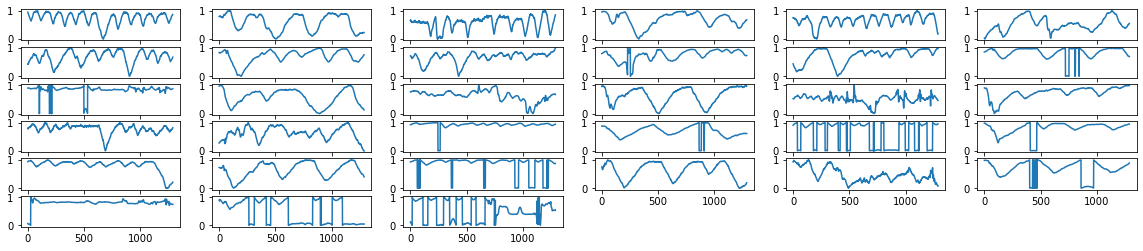

<Figure size 432x288 with 0 Axes>

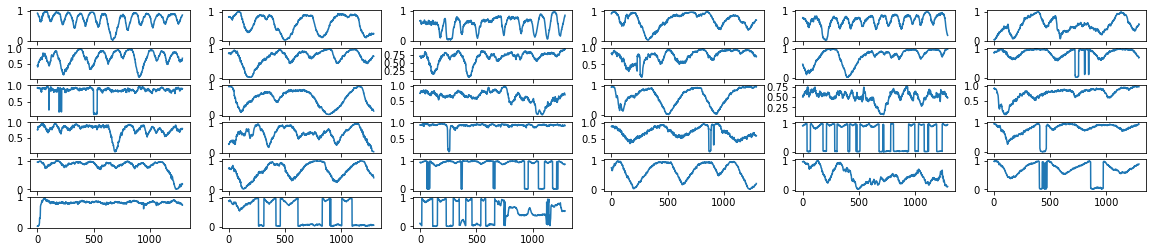

In [60]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])

In [76]:
# leave out person out validation
user_epoch_data = {}
seconds = 30  # time window length

for ident in range(3):
    train_idents = [x for i, x in enumerate(idents) if i != ident]
    validation_idents = [idents[ident]]
    test_idents = [idents[ident]]

    xt_train, yt_train = get_data_from_idents(path, train_idents, seconds)
    xt_valid, yt_valid = get_data_from_idents(path, validation_idents, seconds)
    xt_test, yt_test = get_data_from_idents(path, test_idents, seconds)

    xt_train = np.apply_along_axis(normalize, 1, xt_train)
    xt_valid = np.apply_along_axis(normalize, 1, xt_valid)
    xt_test = np.apply_along_axis(normalize, 1, xt_test)

    # AE Training
    batch_size = 256
    epochs = 1000

    # this is the size of our encoded representations
    encoding_dim = 64
    
    input_data = Input(shape=xt_test[0].shape, name="input")
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(input_data)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(xt_test[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    autoencoder.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    print("\n\nAE TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(autoencoder, xt_train, xt_train, batch_size, epochs, xt_valid, xt_valid, xt_test,xt_test)

    model = autoencoder.get_layer("encoded_signal")
    model.trainable = False
    model = model.output
    # Convolution
    kernel_size = 16
    filters = 16
    strides = 1
    # pooling
    pool_size = 2
    # LSTM
    lstm_output_size = 32

    model = layers.Reshape((-1, 1), input_shape=(encoded.shape)) (model)
    model = Dropout(0.25) (model)

    model = Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu',
                     strides=strides) (model)
    model = MaxPooling1D(pool_size=pool_size) (model)

    model = Dropout(0.25) (model)
    model = LSTM(lstm_output_size, activation='sigmoid') (model)
    model = Dense(1, activation='sigmoid') (model)

    model = Model(inputs=autoencoder.inputs, outputs=model)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Classifier Training
    batch_size = 256
    epochs = 100
    
    print("\n\nCLASSIFICATION TRAINING: ", ident)
    sc, curr_acc, epoch_data = model_train(model, xt_train, yt_train, batch_size, epochs, xt_valid, yt_valid, xt_test,
                                           yt_test)

    epoch_data.history['user_id'] = idents[ident]
    user_epoch_data[idents[ident]] = epoch_data.history

    jsonformat = json.dumps(str(user_epoch_data))
    f = open("./AEOutput/compl2_2_NC_kernel_200_pool_4_filter_64_strides_4_lstm_256.json", "w")
    f.write(jsonformat)
    f.close()

1mpau
7dwjy
7dwjy
7dwjy
7swyk
7swyk
94mnx
94mnx
bd47a
bd47a
bd47a
c24ur
c24ur
c24ur
ctsax
ctsax
ctsax
dkhty
e4gay
e4gay
ef5rq
ef5rq
f1gjp
f1gjp
f1gjp
hpbxa
hpbxa
tn4vl
tn4vl
td5pr
td5pr
gyqu9
fzchw
l53hg
3n2f9
3n2f9
62i9y
62i9y
62i9y
62i9y
62i9y
62i9y
2gu87
2gu87


CLASSIFICATION TRAINING:  0
Train...
34/34 [==============================] - 0s 323us/sample - loss: 1.4781 - accuracy: 0.5000
Test score: 1.4780815861954846
Test accuracy: 0.5
2gu87
1mpau
7dwjy
7dwjy
7dwjy
7swyk
7swyk
94mnx
94mnx
bd47a
bd47a
bd47a
c24ur
c24ur
c24ur
ctsax
ctsax
ctsax
dkhty
e4gay
e4gay
ef5rq
ef5rq
f1gjp
f1gjp
f1gjp
hpbxa
hpbxa
tn4vl
tn4vl
td5pr
td5pr
gyqu9
fzchw
l53hg
3n2f9
3n2f9
62i9y
62i9y
62i9y
62i9y
62i9y
62i9y


CLASSIFICATION TRAINING:  1
Train...
36/36 [==============================] - 0s 305us/sample - loss: 0.5739 - accuracy: 0.8056
Test score: 0.5739123091981229
Test accuracy: 0.8055555555555556
2gu87
7dwjy
7dwjy
7dwjy
7swyk
7swyk
94mnx
94mnx
bd47a
bd47a
bd47a
c24ur
c24ur
c24ur
ctsax
ctsax
ctsax
d

<Figure size 432x288 with 0 Axes>

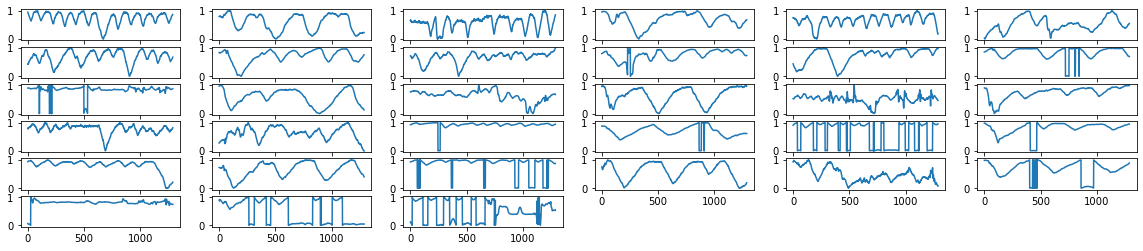

<Figure size 432x288 with 0 Axes>

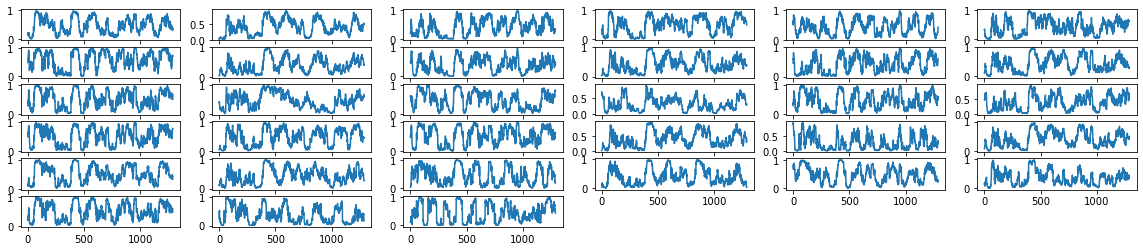

### Sequence-To-Sequence Autoencoders
from https://blog.keras.io/building-autoencoders-in-keras.html

#### Sequence-To-Sequence Autoencoder - Normalized Input Data
Just testing, still work in progress.  
Have to consider a few different layers: TimeDistributed, RepeatVector. And rethink the topology.

In [ ]:
# Convolution
kernel_size = 200
filters = 64
strides = 4
# pooling
pool_size = 4
# LSTM
lstm_output_size = 1290

# x_train = x_train.reshape(-1, x_train[0].shape[0], 1)
# x_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
# x_test = x_test.reshape(-1, x_test[0].shape[0], 1)

model = Sequential()
model.add(layers.Reshape((x_test[0].shape[0],1),input_shape=x_train[0].shape))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=strides))

model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='same',
                 activation='relu',
                 strides=strides))
model.add(MaxPooling1D(pool_size=pool_size))

# model.add(Dropout(0.25))
model.add(LSTM(lstm_output_size))
model.add(Activation('sigmoid'))

autoencoder = model

# input_dim=1290
# latent_dim=1290
# timesteps=1

# inputs = Input(shape=(timesteps, 1290))
# encoded = LSTM(latent_dim)(inputs)

# decoded = layers.RepeatVector(timesteps)(encoded)
# decoded = LSTM(input_dim, return_sequences=True)(decoded)

# autoencoder = Model(inputs, decoded)
# encoder = Model(inputs, encoded)

In [ ]:
y = autoencoder(x_train)
autoencoder.summary()

In [ ]:
# autoencoder.compile(optimizer='adam', loss='MSE')
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training
batch_size = 256
epochs = 50

autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

# sc, curr_acc, epoch_data = model_train(autoencoder, x_train, x_train, batch_size, epochs, x_valid, x_valid, x_test, x_test)

In [ ]:
x_pred = autoencoder.predict(x_train)


#plot n samples to compare
n = 33

#plot the original values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_train[i])
    
#plot the reconstructed values
plt.figure()
plt.figure(figsize=(20, 4))
for i in range(n):
    plt.subplot(n/5, 6, i+1)
    plt.plot(x_pred[i])